<a href="https://colab.research.google.com/github/amousavi9/Anomaly-Detection-using-VAE/blob/main/vae_anomaly_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connecting to Google Drive

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


##Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

##Utilities

In [2]:
def sample_images(images, row_count=1, column_count=4, fig_size=(8,2), title=None):
    fig, axs = plt.subplots(row_count, column_count, figsize=fig_size, squeeze=False)
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    if title is not None:
      plt.suptitle(title, size=12)
    plt.show()

##Import Datasets

In [3]:
batch_size = 64
n_epochs = 20
image_width = 64
image_size  = (image_width, image_width)

In [4]:
root_dir = '/content/drive/MyDrive/chest-xray/chest_xray/'

train_ds = keras.preprocessing.image_dataset_from_directory(
    root_dir + 'train',
    batch_size=batch_size,
    image_size=image_size,
    seed=42,
    label_mode='int'
)

Found 5216 files belonging to 2 classes.


In [5]:
normal_ds = train_ds.unbatch().filter(lambda x, y:  tf.equal(y, 0)).batch(batch_size) 
pneumonia_ds = train_ds.unbatch().filter(lambda x, y:  tf.equal(y, 1)).batch(batch_size) 

In [6]:
def scaling(input_image, categori):
    input_image = input_image / 127.5 - 1.
    return (input_image, categori)

normal_ds = normal_ds.map(scaling)
pneumonia_ds = pneumonia_ds.map(scaling)

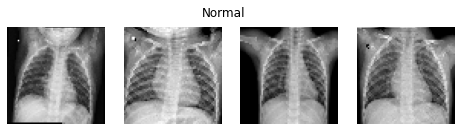

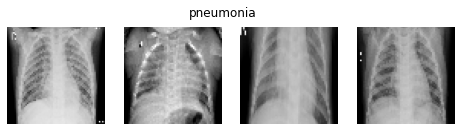

In [7]:
for images, labels in normal_ds.take(1):
    images = ((images.numpy() + 1) * 127.5).astype('int')
    sample_images(images, title='Normal')

for images, labels in pneumonia_ds.take(1):
    images = ((images.numpy() + 1) * 127.5).astype('int')
    sample_images(images, title='pneumonia')

##Model Development

In [8]:
tf.keras.backend.clear_session()

##VAE Model

In [9]:
class VAE(keras.Model):
  def __init__(self):
    super().__init__()

    self.encoder = Sequential([
                        layers.Input(shape=(64,64,3)),
                        layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.1),
                        layers.Dropout(0.1),

                        layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.1),
                        layers.Dropout(0.1),

                        layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.2),
                        layers.Dropout(0.1),

                        layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.2),
                        layers.Dropout(0.1),

                        layers.Flatten()
                               ])

    self.z_mean = layers.Dense(200)
    self.z_log_var = layers.Dense(200)

    self.decoder = Sequential([
                        layers.Dense(1024), # 4*4*64
                        layers.Reshape((4, 4, 64)),

                        layers.UpSampling2D(size=(2, 2)),
                        layers.Conv2D(64, 3, strides=1, padding='same'),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.2),
                        layers.Dropout(0.1),

                        layers.UpSampling2D(size=(2, 2)),
                        layers.Conv2D(64, 3, strides=1, padding='same'),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.3),
                        layers.Dropout(0.1),

                        layers.UpSampling2D(size=(2, 2)),
                        layers.Conv2D(64, 3, strides=1, padding='same'),
                        layers.BatchNormalization(),
                        layers.LeakyReLU(0.3),
                        layers.Dropout(0.1),

                        layers.UpSampling2D(size=(2, 2)),
                        layers.Conv2D(3, 3, strides=1, padding='same', activation='tanh')
                               ])



  def encoding_fn(self, inputs):
    x = self.encoder(inputs)
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    encoded = self.sample_z(z_mean, z_log_var)
    return z_mean


  def sample_z(self, z_mu, z_log_var):
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_log_var / 2) * eps


  def call(self, inputs):
    x = self.encoder(inputs)
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    encoded = self.sample_z(z_mean, z_log_var)
    decoded = self.decoder(encoded)
    return encoded, z_mean, z_log_var, decoded

In [10]:
'''build the Model'''
model = VAE()

##VAE loss

In [11]:
class VAE_Loss(layers.Layer):
  def __init__(self):
    super().__init__()

  def kl_loss(self, mu, sigma):
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    return tf.reduce_mean(kl_loss) * -0.5

  def reconstruction_loss(self, inputs, outputs):
    rec_loss = tf.keras.losses.mse(inputs, outputs)
    return tf.reduce_mean(rec_loss) * (image_width * image_width)

  def call(self, inputs, outputs, mu, sigma):
    klLoss = self.kl_loss(mu, sigma)
    reconstructionLoss = self.reconstruction_loss(inputs, outputs)
    return reconstructionLoss + klLoss

In [12]:
'''Build the Loss'''
vae_loss = VAE_Loss()

##Optimizer

In [13]:
optimizer = tf.keras.optimizers.Adam()

##Train the Model

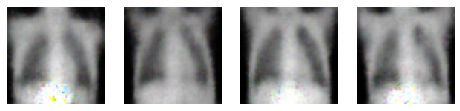

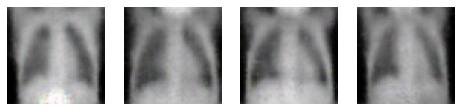

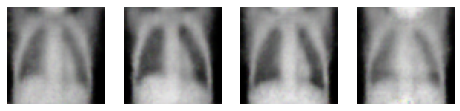

In [15]:
loss_list = []

for epoch in range(n_epochs):
  for x_batch_train in normal_ds:
    x_batch_train = x_batch_train[0]

    with tf.GradientTape() as tape:
      _, z_mean, z_log_var, decoded = model(x_batch_train, training=True)
      losses = vae_loss(x_batch_train, decoded, z_mean, z_log_var)
    
    grads = tape.gradient(losses, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    loss_list.append(losses.numpy())
  if epoch % 5 == 0 and epoch > 0:
    images = ((decoded.numpy() + 1) * 127.5).astype('int')
    sample_images(images, row_count=1, column_count=4, fig_size=(8,4))

##Latent Space Visualization

In [40]:
# get normal images
normal_imgs = []
for batch in normal_ds.take(40):
  for img in batch[0]:
    normal_imgs.append(img)

# get pneumonia images
pneumonia_imgs = []
for batch in pneumonia_ds.take(20):
  for img in batch[0]:
    pneumonia_imgs.append(img)

In [41]:
def plot_label_clusters(model, normal_imgs, pneumonia_imgs):
    data = np.concatenate((normal_imgs, pneumonia_imgs), axis=0)
    z_mean = model.encoding_fn(data)
    tsne_res = TSNE(init='pca', n_components=2, n_jobs = -1, random_state = 22).fit_transform(z_mean) 

    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_res[len(normal_imgs):, 0], tsne_res[len(normal_imgs):, 1], c='tab:purple', label='PNEUMONIA')
    plt.scatter(tsne_res[:len(normal_imgs), 0], tsne_res[:len(normal_imgs), 1], c='tab:green', label='NORMAL')
    plt.legend()
    plt.colorbar()
    plt.xlabel("z [0]")
    plt.ylabel("z [1]")
    plt.show()

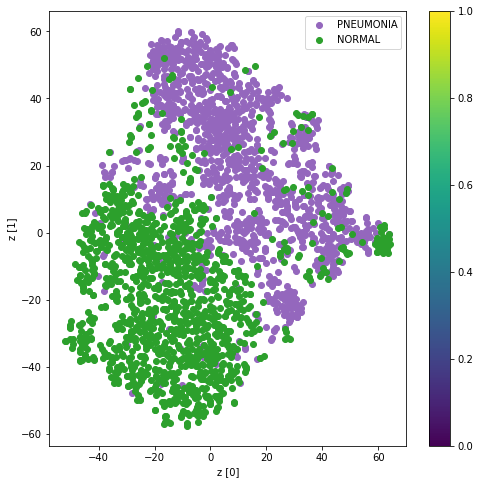

In [42]:
plot_label_clusters(model, normal_imgs, pneumonia_imgs)

## Plotting the Training Loss

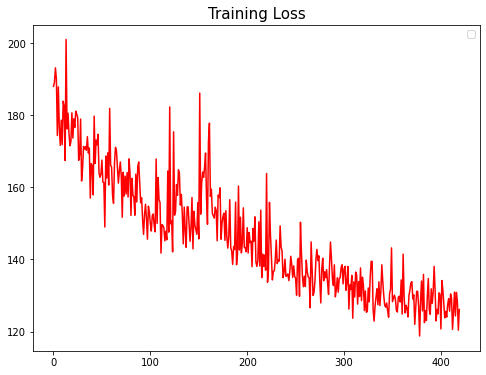

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(loss_list, c='r')
plt.title("Training Loss", fontsize=15)
plt.legend()
plt.show()